In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sqlalchemy import create_engine
from sqlalchemy.sql import text

import baikalfunctions as bfunc
import scheme_mar2023 as scheme
import mytools
import mysecure

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
# pd.set_option('display.min_rows', 100)
%matplotlib inline
plt.style.use('dark_background')   # try another styles: 'classic'
plt.rcParams['figure.figsize'] = [15, 5]
#plt.subplots_adjust(top=1, left=0, right=1, bottom=0)

In [4]:
saveImgPath = 'G:\\1_Data1\\96_BaikalMar2024\\'
saveDataPath = 'G:\\1_Data1\\96_BaikalMar2024\\'
serverPath = 'C:\\xampp\\htdocs\\img\\'

In [ ]:
host = "192.168.3.53"
# host = 'localhost'
tableName = "mar2024"

engine = create_engine(f"mysql+pymysql://{mysecure.user}:{mysecure.password}@{host}:3306/baikal")
# req = f"select * from {tableName} where DateTime > ADDDATE((SELECT DATETIME FROM {tableName} ORDER BY DATETIME DESC LIMIT 1), INTERVAL -24 hour);"
req = f"select * from {tableName}"

In [ ]:
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(req))

df = pd.DataFrame(query.fetchall())

In [16]:
df = pd.read_csv('baikalMar2024_1.txt', sep='\t', parse_dates=['DateTime'], dayfirst=False)

In [17]:
df.tail(5)

,Unnamed: 0,DateTime,Comments,AIR_TEMPERATURE,AIR_TEMPERATURE_err,AIR_PRESSURE,AIR_PRESSURE_err,RAIN,RAIN_err,LIGHT_LX,LIGHT_LX_err,UV,UV_err,V1_state,V1_state_err,V2_state,V2_state_err,V3_state,V3_state_err,V4_state,V4_state_err,V5_state,V5_state_err,V6_state,V6_state_err,V7_state,V7_state_err,V8_state,V8_state_err,PUMP_PROBE_state,PUMP_PROBE_state_err,PUMP_VENTILATION_state,PUMP_VENTILATION_state_err,AIR_FLOW,AIR_FLOW_err,LATITUDE,LATITUDE_err,LONGITUDE,LONGITUDE_err,SPEED,SPEED_err,COURSE,COURSE_err,RELEY_1,RELEY_1_err,RELEY_2,RELEY_2_err,RELEY_3,RELEY_3_err,RELEY_4,...,WATER_FLOW_2,WATER_FLOW_2_err,WATER_FLOW_3,WATER_FLOW_3_err,WATER_FLOW_4,WATER_FLOW_4_err,TEMP_DS1,TEMP_DS1_err,TEMP_DS2,TEMP_DS2_err,TEMP_DS3,TEMP_DS3_err,METEO_LEVEL,METEO_LEVEL_err,METEO_PRESS,METEO_PRESS_err,METEO_TIME,METEO_TIME_err,METEO_TEMP,METEO_TEMP_err,METEO_HUM,METEO_HUM_err,METEO_SOLAR,METEO_SOLAR_err,METEO_WIND_DIR,METEO_WIND_DIR_err,METEO_WIND_SPEED,METEO_WIND_SPEED_err,METEO_WIND_SPEED_MAX,METEO_WIND_SPEED_MAX_err,METEO_RAIN,METEO_RAIN_err,PICARRO_CO2,PICARRO_CO2_err,PICARRO_CH4,PICARRO_CH4_err,PICARRO_H2O,PICARRO_H2O_err,NX_B,NX_B_err,KFA_B,KFA_B_err,NX_G,NX_G_err,KFA_G,KFA_G_err,NX_R,NX_R_err,KFA_R,KFA_R_err
36039,36039,2024-03-27 10:41:00,NaN,2.22533,0.046349,97154.7,6.63181,0.112111,0.000745,50135.0,0.0,122.733,0.539360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8998,0.000021,105.064,0.000010,0.145800,0.120500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.9100,0.031623,10.0820,0.045166,12.4160,0.030984,2859.19,0.806840,727.101,0.018007,1.711510e+09,6.560180e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36040,36040,2024-03-27 10:41:20,NaN,2.53568,0.160760,97157.5,3.96535,0.112114,0.000754,50135.0,0.0,123.273,0.499471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8997,0.000020,105.064,0.000007,0.084600,0.025523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.9640,0.041952,10.1080,0.045166,12.4280,0.025298,2857.66,1.070170,727.119,0.011772,1.711510e+09,5.916080e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36041,36041,2024-03-27 10:41:40,NaN,3.26000,0.193234,97151.9,6.83423,0.112909,0.001951,50135.0,0.0,124.386,0.841259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8997,0.000016,105.064,0.000006,0.059000,0.034892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0140,0.065862,10.1360,0.018974,12.4820,0.028983,2858.66,0.960493,727.067,0.018412,1.711510e+09,6.204840e+00,-5.22,NaN,47.6,NaN,502.77,NaN,151.0,NaN,3.2,NaN,5.8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36042,36042,2024-03-27 10:42:00,NaN,4.07311,0.201481,97142.2,5.14438,0.112556,0.001589,50135.0,0.0,124.578,0.583442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8996,0.000011,105.064,0.000004,0.106733,0.070991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0490,0.040125,10.1720,0.040497,12.4820,0.028983,2859.44,1.103190,727.018,0.012609,1.711510e+09,5.916080e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36043,36043,2024-03-27 19:16:00,NaN,3.06848,0.577654,97119.4,88.36920,0.116458,0.005237,47880.2,10332.4,121.258,25.887600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8996,0.000010,105.064,0.000020,0.138932,0.105049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.9466,3.087000,10.9332,2.995410,13.3099,2.589870,2863.11,14.735800,726.751,0.762312,1.687980e+09,1.996860e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [18]:
df.columns

Index(['Unnamed: 0', 'DateTime', 'Comments', 'AIR_TEMPERATURE',
       'AIR_TEMPERATURE_err', 'AIR_PRESSURE', 'AIR_PRESSURE_err', 'RAIN',
       'RAIN_err', 'LIGHT_LX',
       ...
       'KFA_B', 'KFA_B_err', 'NX_G', 'NX_G_err', 'KFA_G', 'KFA_G_err', 'NX_R',
       'NX_R_err', 'KFA_R', 'KFA_R_err'],
      dtype='object', length=103)

In [19]:
df.rename(columns=scheme.NAME_CONV_BAS, inplace=True)
df.sort_values(by='DateTime', inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(2)

,Unnamed: 0,DateTime,Comments,TempAir,AIR_TEMPERATURE_err,PressAir,AIR_PRESSURE_err,Precipitation,RAIN_err,LightLX,LIGHT_LX_err,LightUV,UV_err,V1_state,V1_state_err,V2_state,V2_state_err,V3_state,V3_state_err,V4_state,V4_state_err,V5_state,V5_state_err,V6_state,V6_state_err,V7_state,V7_state_err,V8_state,V8_state_err,PUMP_PROBE_state,PUMP_PROBE_state_err,PUMP_VENTILATION_state,PUMP_VENTILATION_state_err,AirFlow,AIR_FLOW_err,Latitude,LATITUDE_err,Longitude,LONGITUDE_err,Speed,SPEED_err,Course,COURSE_err,RELEY_1,RELEY_1_err,RELEY_2,RELEY_2_err,RELEY_3,RELEY_3_err,RELEY_4,...,WaterFlowEqu2,WATER_FLOW_2_err,WaterFlowEqu3,WATER_FLOW_3_err,WaterFlowEqu4,WATER_FLOW_4_err,TempEqu1,TEMP_DS1_err,TempEqu2,TEMP_DS2_err,TempEqu3,TEMP_DS3_err,METEO_LEVEL,METEO_LEVEL_err,METEO_PRESS,METEO_PRESS_err,METEO_TIME,METEO_TIME_err,METEO_TEMP,METEO_TEMP_err,METEO_HUM,METEO_HUM_err,METEO_SOLAR,METEO_SOLAR_err,METEO_WIND_DIR,METEO_WIND_DIR_err,METEO_WIND_SPEED,METEO_WIND_SPEED_err,METEO_WIND_SPEED_MAX,METEO_WIND_SPEED_MAX_err,METEO_RAIN,METEO_RAIN_err,vCO2,vCO2Err,vCH4,vCH4Err,vH2O,vH2OErr,FluoNxBlu,NX_B_err,FluoKfaBlu,KFA_B_err,FluoNxGrn,NX_G_err,FluoKfaGrn,KFA_G_err,FluoNxRed,NX_R_err,FluoKfaRed,KFA_R_err
0,0,2024-03-18 22:24:00,NaN,4.61182,0.008739,96980.0,1.79789,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.476000,0.005164,51.8997,0.000000,105.064,0.000000,0.110,0.075941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.940,0.000000,25.120,0.000000,26.590,0.042426,2959.67,0.049497,725.786,0.000707,1.710770e+09,0.707107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-03-18 22:24:20,NaN,4.68886,0.054824,96980.3,1.54039,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.470227,0.003402,51.8997,0.000005,105.064,0.000004,0.164,0.153219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.898,0.036148,25.127,0.022136,26.524,0.030984,2959.76,0.062648,725.782,0.001327,1.710770e+09,6.204840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.sort_values(by='DateTime', inplace=True)

In [21]:
### remove service variables
df.drop([x for x in df.columns if x.lower().endswith('err')], axis='columns', inplace=True, errors='ignore')
df.drop([x for x in df.columns if x.lower().endswith('max')], axis='columns', inplace=True, errors='ignore')
df.drop([x for x in df.columns if x.lower().endswith('min')], axis='columns', inplace=True, errors='ignore')
df.drop([x for x in df.columns if x.lower().startswith('pump')], axis='columns', inplace=True, errors='ignore')
df.drop(['HumidityAir', ], axis='columns', inplace=True, errors='ignore')


In [22]:
df.shape, df.columns

((36044, 50),
 Index(['Unnamed: 0', 'DateTime', 'Comments', 'TempAir', 'PressAir',
        'Precipitation', 'LightLX', 'LightUV', 'V1_state', 'V2_state',
        'V3_state', 'V4_state', 'V5_state', 'V6_state', 'V7_state', 'V8_state',
        'AirFlow', 'Latitude', 'Longitude', 'Speed', 'Course', 'RELEY_1',
        'RELEY_2', 'RELEY_3', 'RELEY_4', 'WaterFlowEqu1', 'WaterFlowEqu2',
        'WaterFlowEqu3', 'WaterFlowEqu4', 'TempEqu1', 'TempEqu2', 'TempEqu3',
        'METEO_LEVEL', 'METEO_PRESS', 'METEO_TIME', 'METEO_TEMP', 'METEO_HUM',
        'METEO_SOLAR', 'METEO_WIND_DIR', 'METEO_WIND_SPEED', 'METEO_RAIN',
        'vCO2', 'vCH4', 'vH2O', 'FluoNxBlu', 'FluoKfaBlu', 'FluoNxGrn',
        'FluoKfaGrn', 'FluoNxRed', 'FluoKfaRed'],
       dtype='object'))

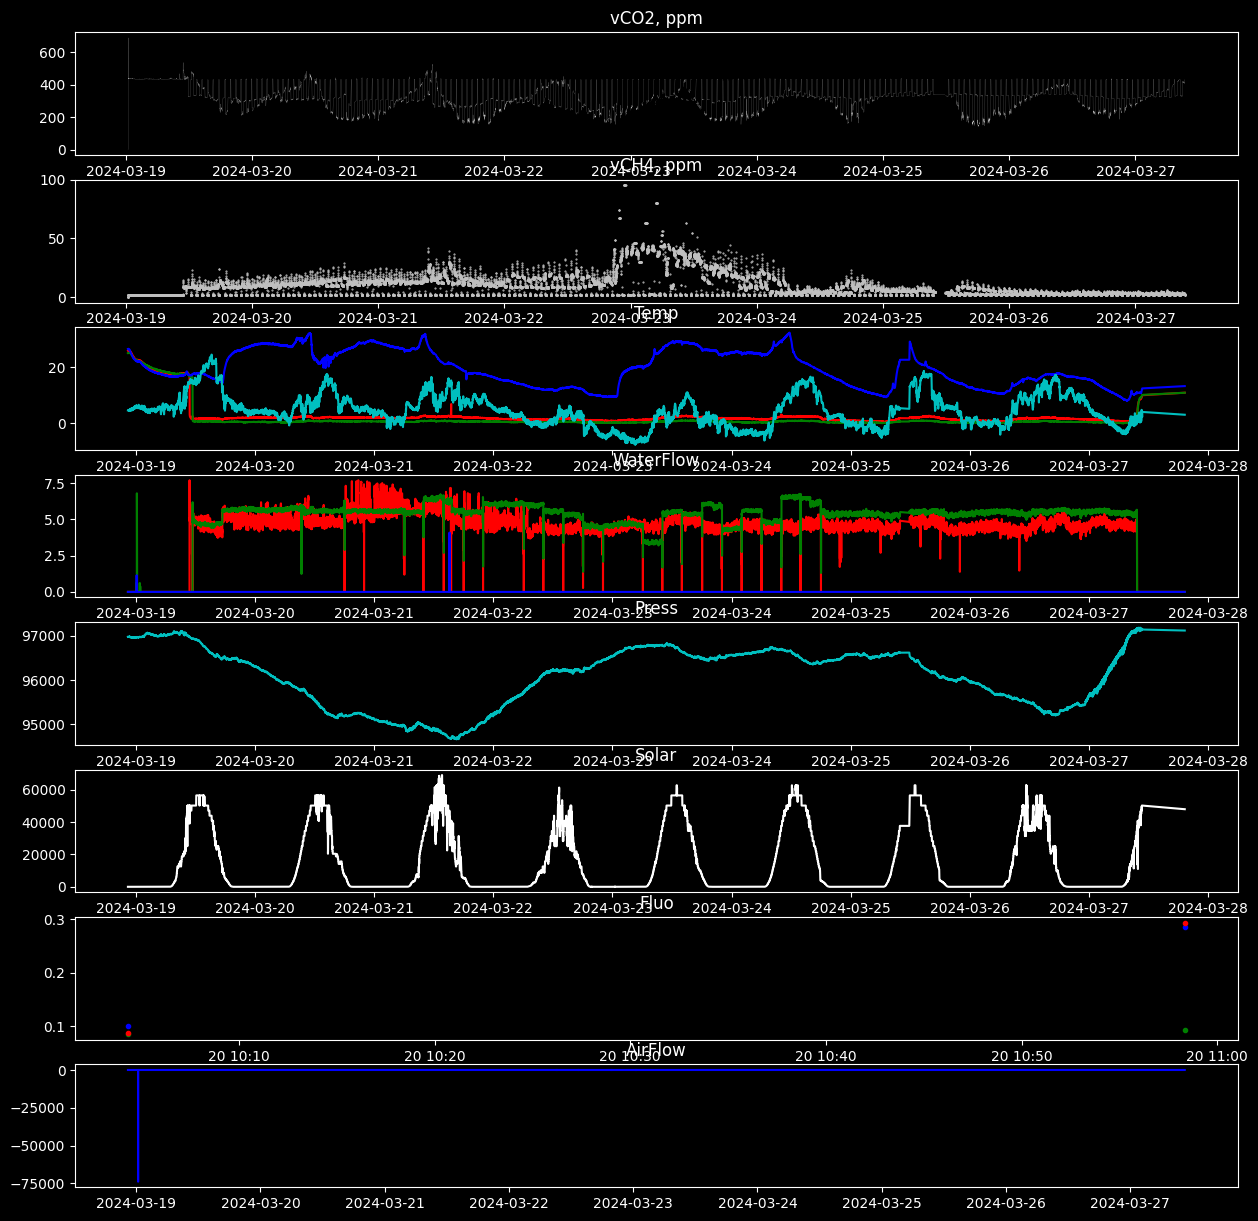

In [23]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(8, 1)

axs[0].set_title('vCO2, ppm')
axs[0].plot(df.DateTime, df['vCO2'], '-', c='silver', linewidth=0.1)

axs[1].set_title('vCH4, ppm')
axs[1].plot(df.DateTime, df['vCH4'], '.', c='silver', markersize=1)

axs[2].set_title('Temp')
axs[2].plot(df.DateTime, df['TempEqu1'], 'r-')
axs[2].plot(df.DateTime, df['TempEqu2'], 'g-')
axs[2].plot(df.DateTime, df['TempEqu3'], 'b-')
axs[2].plot(df.DateTime, df['TempAir'], 'c-')

axs[3].set_title('WaterFlow')
axs[3].plot(df.DateTime, df['WaterFlowEqu1'], 'r-')
axs[3].plot(df.DateTime, df['WaterFlowEqu2'], 'g-')
axs[3].plot(df.DateTime, df['WaterFlowEqu3'], 'b-')

axs[4].set_title('Press')
axs[4].plot(df.DateTime, df['PressAir'], 'c-')
axs[5].set_title('Solar')
axs[5].plot(df.DateTime, df['LightLX'], 'w-')
axs[6].set_title('Fluo')
axs[6].plot(df.DateTime, df['FluoKfaBlu'], 'b.')
axs[6].plot(df.DateTime, df['FluoKfaGrn'], 'g.')
axs[6].plot(df.DateTime, df['FluoKfaRed'], 'r.')
axs[7].set_title('AirFlow')
axs[7].plot(df.DateTime, df['AirFlow'], 'b-')



### Correction data

In [24]:
## gether/apply specific variables
### data corrections
# df['vCO2'] = df['vCO2'] * scheme.CO2PicarroScaut_cor[0] + scheme.CO2PicarroScaut_cor[1]
# df['vCH4'] = df['vCH4'] * scheme.CH4PicarroScaut_cor[0] + scheme.CH4PicarroScaut_cor[1]
# df['vCO2'] = df['CO2_dry']
# df['vCH4'] = df['CH4_dry']
df['LightLX'] = df['LightLX'] * scheme.solar_cor[0] + scheme.solar_cor[1]
df['LightUV'] = df['LightUV'] * scheme.solar_uv_cor[0] + scheme.solar_uv_cor[1]
df['PressAir'] = bfunc.pressConvert(df['PressAir'])
df['PressAir'] = df['PressAir'] * scheme.press_cor[0] + scheme.press_cor[1]

### servise data corrections
df['TempEqu1'] = df['TempEqu1'] * scheme.tempEqu1_cor[0] + scheme.tempEqu1_cor[1]
df['TempEqu2'] = df['TempEqu2'] * scheme.tempEqu2_cor[0] + scheme.tempEqu2_cor[1]
df['TempEqu3'] = df['TempEqu3'] * scheme.tempEqu3_cor[0] + scheme.tempEqu3_cor[1]

df['AirFlow'] = df['AirFlow'] * scheme.airflow_cor[0] + scheme.airflow_cor[1]
df['WaterFlowEqu1'] = df['WaterFlowEqu1'] * scheme.waterflowEqu1_cor[0] + scheme.waterflowEqu1_cor[1]
df['WaterFlowEqu2'] = df['WaterFlowEqu2'] * scheme.waterflowEqu2_cor[0] + scheme.waterflowEqu2_cor[1]
df['WaterFlowEqu3'] = df['WaterFlowEqu3'] * scheme.waterflowEqu3_cor[0] + scheme.waterflowEqu3_cor[1]

In [25]:
v_state_list = list(scheme.CHANNEL_COLS.values())

chnl = 'Channel'
if not chnl in df.columns:
    df[chnl] = 0
if 'V1_state' in df.columns:
    df.loc[df.V1_state == 1, chnl] = 1
    df.loc[df.V2_state == 1, chnl] = 2
    df.loc[df.V3_state == 1, chnl] = 3
    df.loc[df.V4_state == 1, chnl] = 4
    df.loc[df.V5_state == 1, chnl] = 5
    df.loc[df.V6_state == 1, chnl] = 6
df.drop(v_state_list, inplace=True, errors='ignore')

###  Remove bad data   
List of accidental cases to filter data (see notes)

In [26]:
filter_list = [{'date_start': '01.08.2023 00:00', 'date_stop': '19.03.2024 12:00', 'cols': [x for x in df.columns], 'fill_with': np.NaN},   # Picarro is not ready
               {'date_start': '21.03.2024 15:26', 'date_stop': '21.03.2024 15:32', 'cols': ['TempEqu1', 'WaterFlowEqu1'], 'fill_with': np.NaN},   # Water flow meter replaced
               {'date_start': '04.08.2023 12:26', 'date_stop': '04.08.2023 14:39', 'cols': ['WaterFlowEqu1'], 'fill_with': 0},       # water flow unstable
              ]

for cycle in filter_list:
    for col in cycle['cols']:
        date_start = pd.to_datetime(cycle['date_start'], dayfirst=True)
        date_stop = pd.to_datetime(cycle['date_stop'], dayfirst=True)
        df.loc[(df['DateTime'] > date_start) & (df['DateTime'] < date_stop), col] = cycle['fill_with']

In [27]:
cols = ['FluoNxRed', 'FluoNxGrn', 'FluoNxBlu', 'FluoKfaRed', 'FluoKfaGrn', 'FluoKfaBlu']
for col in cols:
    df.loc[df[col] == 0, col] = np.NaN

In [28]:
cols = ['WaterFlowEqu1', 'WaterFlowEqu2', 'WaterFlowEqu3', 'WaterFlowEqu4', 'AirFlow']
for col in cols:
    df.loc[df[col] < 0, col] = np.NaN

In [29]:
df['reff'] = 1
df = df.resample('20S', on='DateTime').mean()
df[chnl].fillna(method='ffill', inplace=True)
ch_v = 'Chn_valid'
df[ch_v] = 1
for deep in range(1, 7):
    df.loc[df[chnl] != df[chnl].shift(deep), ch_v] = 0
df.dropna(axis='index', subset=['reff'], inplace=True)

In [30]:
df['DateTime'] = df.index
df

,Unnamed: 0,Comments,TempAir,PressAir,Precipitation,LightLX,LightUV,V1_state,V2_state,V3_state,V4_state,V5_state,V6_state,V7_state,V8_state,AirFlow,Latitude,Longitude,Speed,Course,RELEY_1,RELEY_2,RELEY_3,RELEY_4,WaterFlowEqu1,WaterFlowEqu2,WaterFlowEqu3,WaterFlowEqu4,TempEqu1,TempEqu2,TempEqu3,METEO_LEVEL,METEO_PRESS,METEO_TIME,METEO_TEMP,METEO_HUM,METEO_SOLAR,METEO_WIND_DIR,METEO_WIND_SPEED,METEO_RAIN,vCO2,vCH4,vH2O,FluoNxBlu,FluoKfaBlu,FluoNxGrn,FluoKfaGrn,FluoNxRed,FluoKfaRed,Channel,reff,Chn_valid,DateTime
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-19 12:00:00,2403.0,NaN,15.97250,0.956437,0.000000,573.143320,0.031186,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.176294,0.0,0.0,0.0,0.0,0.0,4.945,4.813,0.0,0.0,2.1100,0.4600,17.6210,2927.77,725.828,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,328.846,8.36070,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:00
2024-03-19 12:00:20,2404.0,NaN,15.94710,0.956443,0.000000,573.143320,0.031325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.145467,0.0,0.0,0.0,0.0,0.0,4.813,4.865,0.0,0.0,2.1220,0.4900,17.6270,2927.83,725.827,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,328.508,8.36895,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:20
2024-03-19 12:00:40,2405.0,NaN,15.91840,0.956445,0.000000,573.143320,0.031205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.070286,0.0,0.0,0.0,0.0,0.0,4.839,4.904,0.0,0.0,2.1100,0.4840,17.5970,2928.02,725.817,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.993,8.40070,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:40
2024-03-19 12:01:00,2406.0,NaN,15.92250,0.956427,0.000000,573.143320,0.031214,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8997,105.064,0.084312,0.0,0.0,0.0,0.0,0.0,4.774,4.865,0.0,0.0,2.0920,0.4900,17.5720,2927.79,725.845,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.810,8.43550,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:01:00
2024-03-19 12:01:20,2407.0,NaN,15.92110,0.956426,0.000000,573.143320,0.031220,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8997,105.064,0.097625,0.0,0.0,0.0,0.0,0.0,4.774,4.917,0.0,0.0,2.1030,0.5020,17.5600,2928.05,725.842,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.930,8.45720,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:01:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27 10:41:00,36039.0,NaN,2.22533,0.958842,0.112111,573.143320,0.026915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8998,105.064,0.145800,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,10.3600,9.8820,12.4160,2859.19,727.101,1.711510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,2024-03-27 10:41:00
2024-03-27 10:41:20,36040.0,NaN,2.53568,0.958870,0.112114,573.143320,0.027034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8997,105.064,0.084600,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,10.4140,9.9080,12.4280,2857.66,727.119,1.711510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,2024-03-27 10:41:20
2024-03-27 10:41:40,36041.0,NaN,3.26000,0.958815,0.112909,573.143320,0.027278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8997,105.064,0.059000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,10.4640,9.9360,12.4820,2858.66,727.067,1.711510e+09,-5.22,47.6,502.77,151.0,3.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,2024-03-27 10:41:40


In [31]:
df['vCO2air'] = df['vCO2'][(df[chnl] == 6) & (df[ch_v] == 1)]
df['vCH4air'] = df['vCH4'][(df[chnl] == 6) & (df[ch_v] == 1)]
for col in ['vCO2air', 'vCH4air',]:
    df[col] = df[col].rolling(3).mean()

df['vCO2air'].interpolate(method='values', inplace=True)
df['vCH4air'].interpolate(method='values', inplace=True)  ## `time` method mb better
df['pCO2air'] = df['vCO2air'] * df['PressAir']  # mkatm
df['pCH4air'] = df['vCH4air'] * df['PressAir']  # mkatm

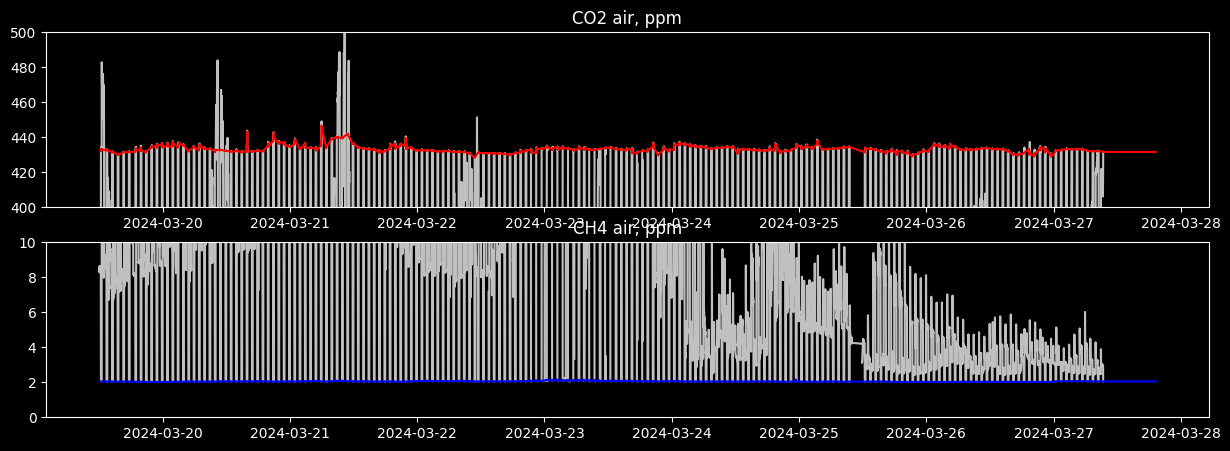

In [32]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 1)

axs[0].set_title('CO2 air, ppm')
axs[0].set_ylim(400, 500)
axs[0].plot(df.DateTime, df['vCO2'], '-', c='silver')
axs[0].plot(df.DateTime, df['vCO2air'], 'r-')

axs[1].set_title('CH4 air, ppm')
axs[1].set_ylim(0, 10)
axs[1].plot(df.DateTime, df['vCH4'], '-', c='silver')
axs[1].plot(df.DateTime, df['vCH4air'], 'b-')
fig.savefig(saveImgPath+'cAir_vs_time.png', transparent=False)

In [33]:
df['pCO2'] = df['vCO2'] * df['PressAir']
df['pCH4'] = df['vCH4'] * df['PressAir']

In [34]:
df.columns

Index(['Unnamed: 0', 'Comments', 'TempAir', 'PressAir', 'Precipitation',
       'LightLX', 'LightUV', 'V1_state', 'V2_state', 'V3_state', 'V4_state',
       'V5_state', 'V6_state', 'V7_state', 'V8_state', 'AirFlow', 'Latitude',
       'Longitude', 'Speed', 'Course', 'RELEY_1', 'RELEY_2', 'RELEY_3',
       'RELEY_4', 'WaterFlowEqu1', 'WaterFlowEqu2', 'WaterFlowEqu3',
       'WaterFlowEqu4', 'TempEqu1', 'TempEqu2', 'TempEqu3', 'METEO_LEVEL',
       'METEO_PRESS', 'METEO_TIME', 'METEO_TEMP', 'METEO_HUM', 'METEO_SOLAR',
       'METEO_WIND_DIR', 'METEO_WIND_SPEED', 'METEO_RAIN', 'vCO2', 'vCH4',
       'vH2O', 'FluoNxBlu', 'FluoKfaBlu', 'FluoNxGrn', 'FluoKfaGrn',
       'FluoNxRed', 'FluoKfaRed', 'Channel', 'reff', 'Chn_valid', 'DateTime',
       'vCO2air', 'vCH4air', 'pCO2air', 'pCH4air', 'pCO2', 'pCH4'],
      dtype='object')

## RECOVERY !!!

In [35]:
df['DateSec'] = df['DateTime'].astype('int64') //10**9
df['dTSec'] = df['DateSec'] - df['DateSec'].shift(1)
dt = df['dTSec'] / 60   ## delta time, min
ch_v = 'Chn_valid'

#### recovery `CO2/CH4`, channel `1` (bottom in mar 2024)

In [36]:
equ_vol = scheme.equ_walltube_param['equ_vol']  # equivalent equ volume, l
equ_cap = scheme.equ_walltube_param['equ_cap']  # equilibrator capacity
wtr_flow_min = scheme.equ_walltube_param['water_flow_min'] 

In [37]:
t_wtr = df['TempEqu1']
t_air = t_wtr
wtr_flow = df['WaterFlowEqu1']
air_flow = df['AirFlow']

In [38]:
### CO2 water
vGasEqu = df['vCO2'][(df[chnl] == 1) & (df[ch_v] == 1) & (wtr_flow > wtr_flow_min)]
solubility = bfunc.getSolubility(t_wtr, 'CO2')

density = bfunc.getDensity(t_air, df['PressAir'], 'CO2')
cGasAir = df['pCO2air'] / 1000000 * density
pGasEquAir = vGasEqu * df['PressAir']  # uatm
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)

df['cCO2bot'] = cGasWtr * 1000     # mg/l
df['pCO2bot'] = cGasWtr * 1000000 / solubility  # mkatm

In [39]:
### CH4 water
vGasEqu = df['vCH4'][(df[chnl] == 1) & (df[ch_v] == 1) & (wtr_flow > wtr_flow_min)]
solubility = bfunc.getSolubility(t_wtr, 'CH4')

density = bfunc.getDensity(t_air, df['PressAir'], 'CH4')
cGasAir = df['pCH4air'] / 1000000 * density
pGasEquAir = vGasEqu * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)
df['cCH4bot'] = cGasWtr * 1000000000    # ng/l
df['pCH4bot'] = cGasWtr * 1000000 / solubility  # mkatm

#### recovery `CO2/CH4`, channel `2` (surface in mar 2024)

In [40]:
t_wtr = df['TempEqu2']
t_air = t_wtr
wtr_flow = df['WaterFlowEqu2']

In [41]:
### CO2 water
vGasEqu = df['vCO2'][(df[chnl] == 2) & (df[ch_v] == 1) & (wtr_flow > wtr_flow_min)]
solubility = bfunc.getSolubility(t_wtr, 'CO2')

density = bfunc.getDensity(t_air, df['PressAir'], 'CO2')
cGasAir = df['pCO2air'] / 1000000 * density
pGasEquAir = vGasEqu * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)

df['cCO2sur'] = cGasWtr * 1000     # mg/l
df['pCO2sur'] = cGasWtr * 1000000 / solubility  # mkatm

In [42]:
### CH4 water
vGasEqu = df['vCH4'][(df[chnl] == 2) & (df[ch_v] == 1) & (wtr_flow > wtr_flow_min)]
solubility = bfunc.getSolubility(t_wtr, 'CH4')

density = bfunc.getDensity(t_air, df['PressAir'], 'CH4')
cGasAir = df['pCH4air'] / 1000000 * density
pGasEquAir = vGasEqu * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)
df['cCH4sur'] = cGasWtr * 1000000000    # ng/l
df['pCH4sur'] = cGasWtr * 1000000 / solubility  # mkatm

In [43]:
## rolling average is applied inplace. Be cafelly, run this cell **ONCE**

for col in ['cCO2sur', 'cCO2bot', 'pCO2sur', 'pCO2bot', 'cCH4sur', 'pCH4sur', 'cCH4bot', 'pCH4bot']:
    df.loc[df[col] == np.inf , col] = np.nan 
    df.loc[df[col] == -np.inf , col] = np.nan
    df.loc[df[col] <= 0 , col] = np.nan
    df[col] = df[col].rolling(4, center=True).mean()

df['cCH4bot'].describe()

count    11379.000000
mean      1580.982234
std       1572.871337
min        207.290419
25%        633.971677
50%       1244.082655
75%       1528.873862
max      15182.142352
Name: cCH4bot, dtype: float64

## Generate charts for server

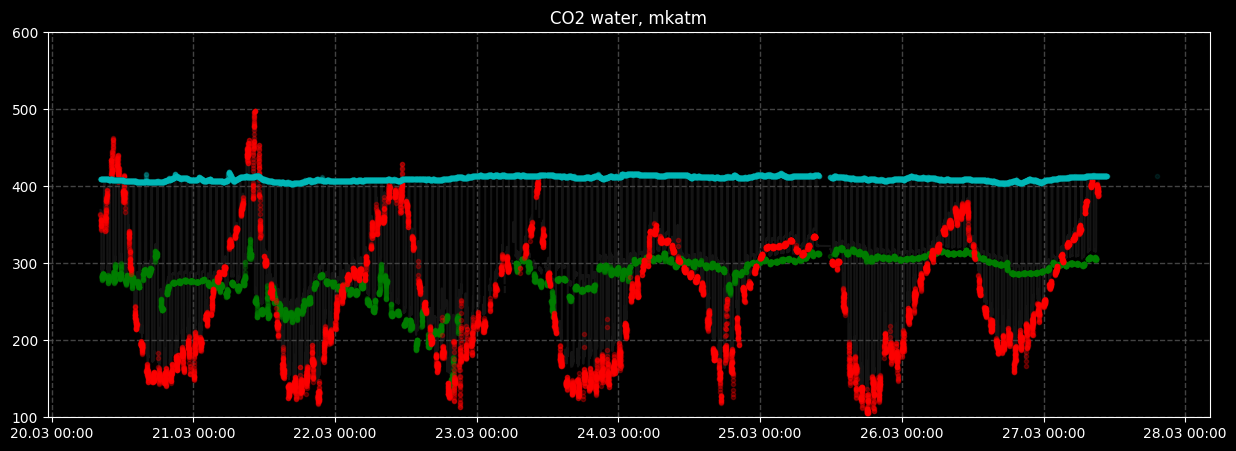

In [44]:
count_recent = 30000

plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
## ax.set_xlim(pd.to_datetime('05.06.2023 18:00:00', dayfirst=True), pd.to_datetime('05.06.2023 19:00:00', dayfirst=True))
ax.set_title('CO2 water, mkatm')
ax.set_ylim(100, 600)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2'], '-', c='#444', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2sur'], 'g.', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2bot'], 'r.', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2air'], 'c.', alpha=0.1)

ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))

fig.savefig(serverPath+'pCO2wtr_vs_time.png', bbox_inches='tight')

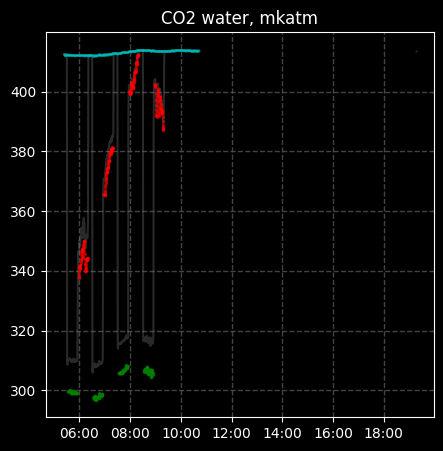

In [45]:
count_recent = 960

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
## ax.set_xlim(pd.to_datetime('05.06.2023 18:00:00', dayfirst=True), pd.to_datetime('05.06.2023 19:00:00', dayfirst=True))
ax.set_title('CO2 water, mkatm')
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2'], '-', c='#888', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2sur'], 'g.', alpha=0.5, markersize=3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2bot'], 'r.', alpha=0.5, markersize=3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCO2air'], 'c.', alpha=0.3, markersize=1)

ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

fig.savefig(serverPath+'pCO2wtr_vs_time_3h.png', bbox_inches='tight')

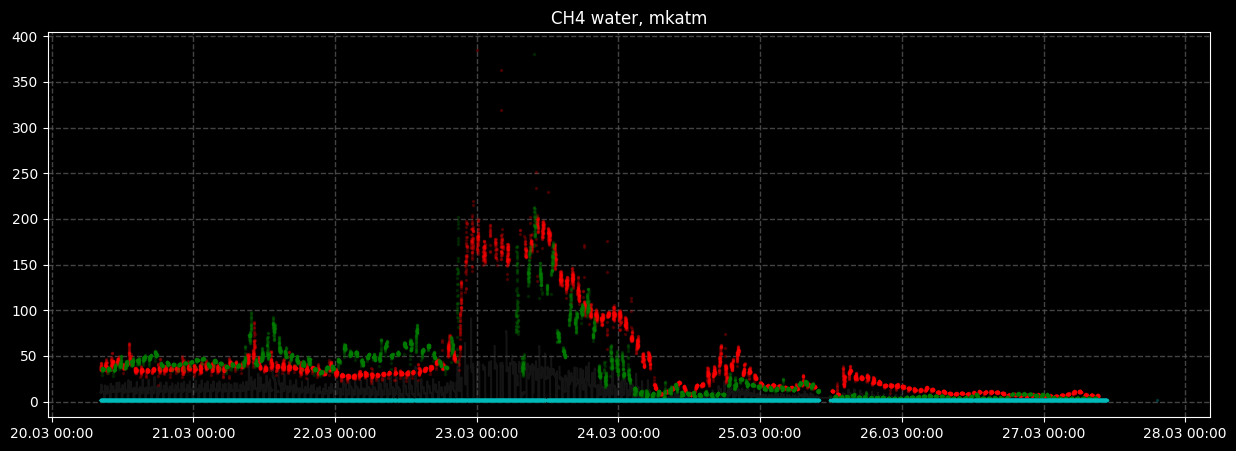

In [46]:
count_recent = 30000

plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.set_title('CH4 water, mkatm')
# ax.set_xlim(pd.to_datetime('06.06.2023 10:00:00', dayfirst=True), pd.to_datetime('06.06.2023 19:00:00', dayfirst=True))
# ax.set_ylim(0, 20)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4'], '-', c='#444', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4bot'], 'r.', alpha=0.2, markersize=3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4sur'], 'g.', alpha=0.2, markersize=3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4air'], 'c.', alpha=0.2, markersize=3)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))
fig.savefig(serverPath+'pCH4wtr_vs_time.png', bbox_inches='tight')

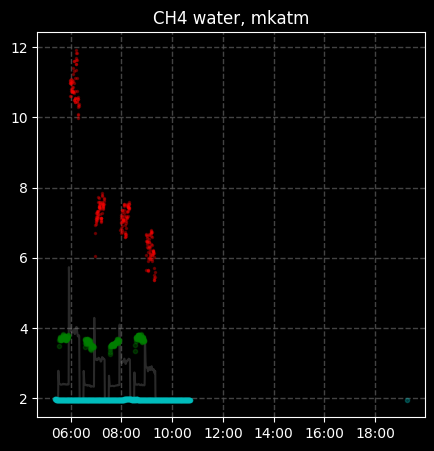

In [47]:
count_recent = 960

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.set_title('CH4 water, mkatm')
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4'], '-', c='#888', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4bot'], 'r.', alpha=0.3, markersize = 3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4sur'], 'g.', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['pCH4air'], 'c.', alpha=0.3)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.savefig(serverPath+'pCH4wtr_vs_time_3h.png', bbox_inches='tight')

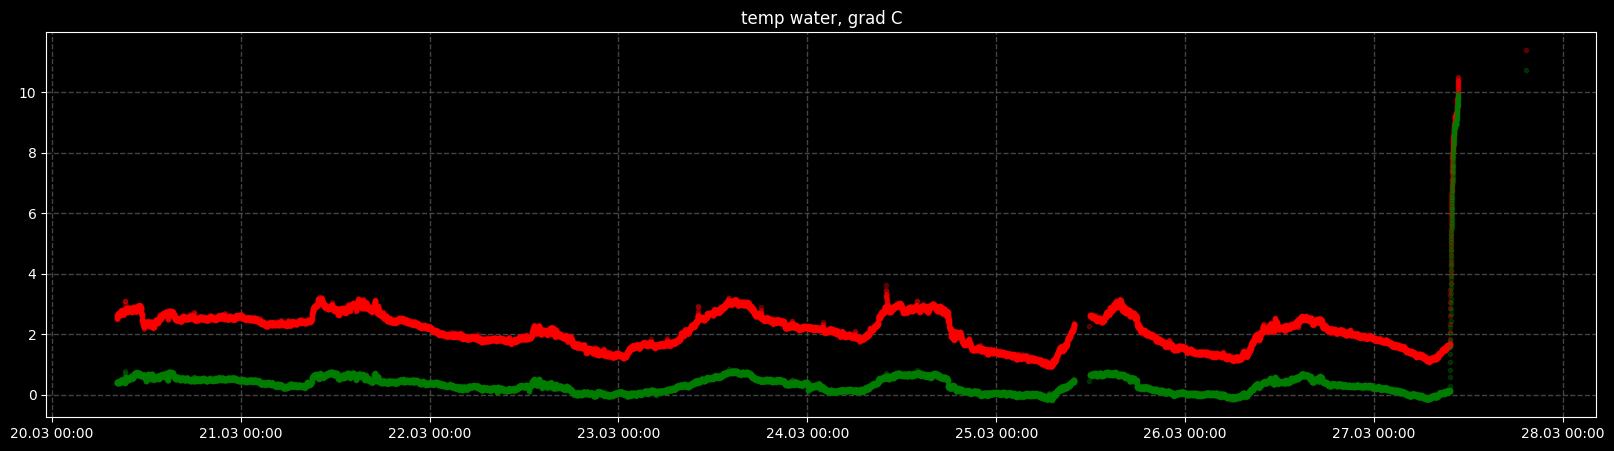

In [48]:
count_recent = 30000

plt.rcParams['figure.figsize'] = [20, 5]
fig, ax = plt.subplots()
ax.set_title('temp water, grad C')
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['TempEqu1'], 'r.', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['TempEqu2'], 'g.', alpha=0.3)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))
fig.savefig(serverPath+'tempWtr_vs_time.png', bbox_inches='tight')

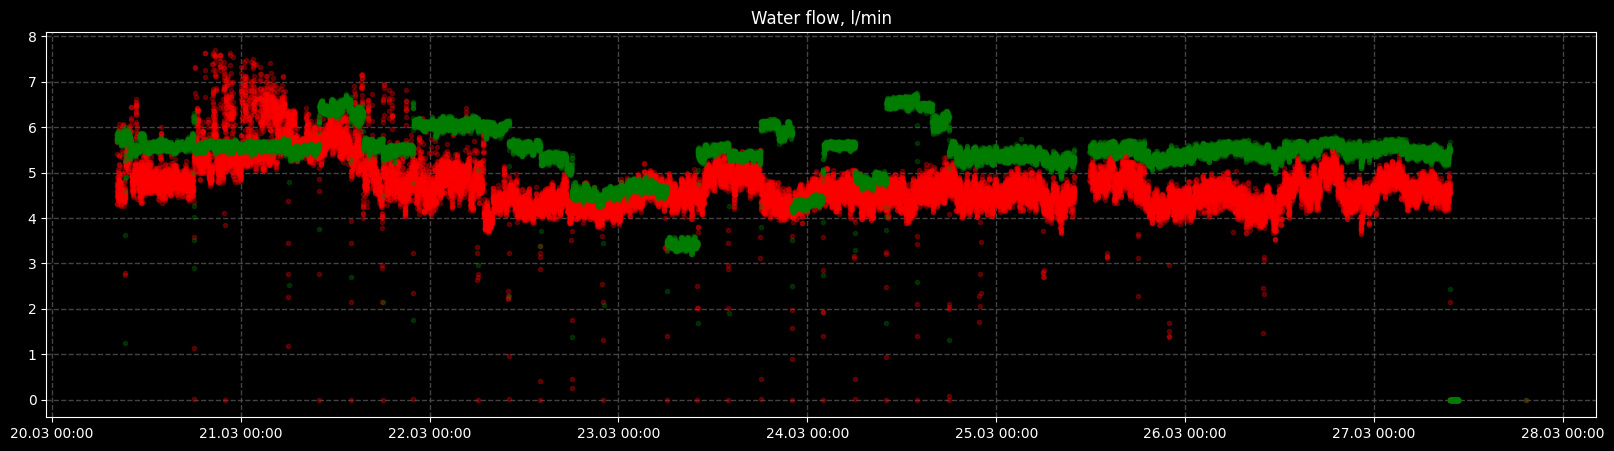

In [49]:
count_recent = 30000

plt.rcParams['figure.figsize'] = [20, 5]
fig, ax = plt.subplots()
ax.set_title('Water flow, l/min')
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['WaterFlowEqu1'], 'r.', alpha=0.3)
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['WaterFlowEqu2'], 'g.', alpha=0.3)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))
fig.savefig(serverPath+'waterFlow_vs_time.png', bbox_inches='tight')

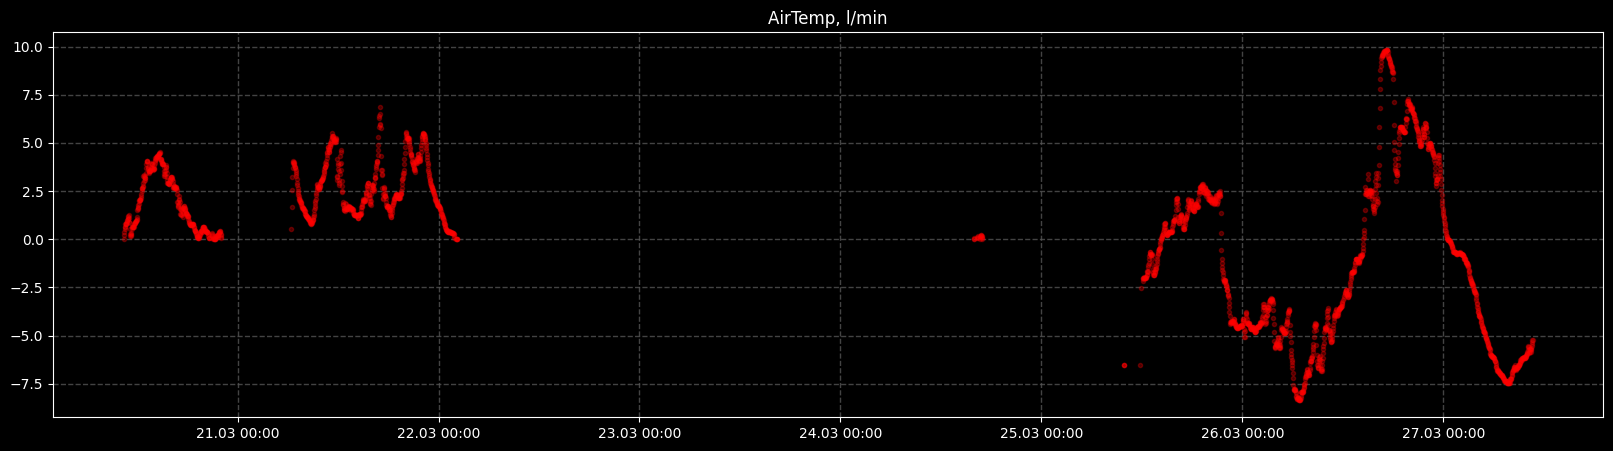

In [50]:
count_recent = 30000

plt.rcParams['figure.figsize'] = [20, 5]
fig, ax = plt.subplots()
ax.set_title('AirTemp, l/min')
ax.plot(df.tail(count_recent).DateTime, df.tail(count_recent)['METEO_TEMP'], 'r.', alpha=0.3)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%d.%m %H:%M'))
fig.savefig(serverPath+'TempAir_vs_time.png', bbox_inches='tight')

In [51]:
df.columns

Index(['Unnamed: 0', 'Comments', 'TempAir', 'PressAir', 'Precipitation',
       'LightLX', 'LightUV', 'V1_state', 'V2_state', 'V3_state', 'V4_state',
       'V5_state', 'V6_state', 'V7_state', 'V8_state', 'AirFlow', 'Latitude',
       'Longitude', 'Speed', 'Course', 'RELEY_1', 'RELEY_2', 'RELEY_3',
       'RELEY_4', 'WaterFlowEqu1', 'WaterFlowEqu2', 'WaterFlowEqu3',
       'WaterFlowEqu4', 'TempEqu1', 'TempEqu2', 'TempEqu3', 'METEO_LEVEL',
       'METEO_PRESS', 'METEO_TIME', 'METEO_TEMP', 'METEO_HUM', 'METEO_SOLAR',
       'METEO_WIND_DIR', 'METEO_WIND_SPEED', 'METEO_RAIN', 'vCO2', 'vCH4',
       'vH2O', 'FluoNxBlu', 'FluoKfaBlu', 'FluoNxGrn', 'FluoKfaGrn',
       'FluoNxRed', 'FluoKfaRed', 'Channel', 'reff', 'Chn_valid', 'DateTime',
       'vCO2air', 'vCH4air', 'pCO2air', 'pCH4air', 'pCO2', 'pCH4', 'DateSec',
       'dTSec', 'cCO2bot', 'pCO2bot', 'cCH4bot', 'pCH4bot', 'cCO2sur',
       'pCO2sur', 'cCH4sur', 'pCH4sur'],
      dtype='object')

In [52]:
df['hour'] = df['DateTime'].dt.hour # + df['DateTime'].dt.minute / 60 # discomment for 
df['hour']

DateTime
2024-03-19 12:00:00    12
2024-03-19 12:00:20    12
2024-03-19 12:00:40    12
2024-03-19 12:01:00    12
2024-03-19 12:01:20    12
                       ..
2024-03-27 10:41:00    10
2024-03-27 10:41:20    10
2024-03-27 10:41:40    10
2024-03-27 10:42:00    10
2024-03-27 19:16:00    19
Name: hour, Length: 33641, dtype: int64

In [53]:
cols = ['hour', 'DateSec', 'TempAir', 'PressAir', 'Precipitation', 'LightLX', 'LightUV',
        'METEO_LEVEL', 'METEO_PRESS', 'METEO_TEMP', 'METEO_HUM', 'METEO_SOLAR', 'METEO_WIND_DIR', 'METEO_WIND_SPEED', 'METEO_RAIN',
        'vCO2', 'vCH4', 'vH2O', 'AirFlow', 'Channel',
        #'FluoNxRed', 'FluoNxGrn', 'FluoNxBlu', 'FluoKfaRed', 'FluoKfaGrn', 'FluoKfaBlu', 'WaterFlowEqu1',
        'WaterFlowEqu2', 'WaterFlowEqu3', 'WaterFlowEqu4',
        'TempEqu1', 'TempEqu2', 'TempEqu3',
        # 'cCO2chm', 'cCH4chm', 'CO2flux', 'CH4flux',
        'vCO2air', 'vCH4air',
        'pCO2air', 'pCH4air', 'cCO2sur', 'pCO2sur',
        'cCH4sur', 'pCH4sur', 'cCO2bot', 'pCO2bot', 'cCH4bot', 'pCH4bot',]
df.to_csv(f'{saveDataPath}origin.txt',
          columns=cols,
          sep='\t',
         )

In [61]:
hourly = df.resample('60T', on='DateTime', offset='30T').mean()
hourly.index = hourly.index + pd.to_timedelta('30T')
hourly.to_csv(f'{saveDataPath}hourly.txt',
              columns=cols,
              sep='\t',
             )

In [55]:
df

,Unnamed: 0,Comments,TempAir,PressAir,Precipitation,LightLX,LightUV,V1_state,V2_state,V3_state,V4_state,V5_state,V6_state,V7_state,V8_state,AirFlow,Latitude,Longitude,Speed,Course,RELEY_1,RELEY_2,RELEY_3,RELEY_4,WaterFlowEqu1,WaterFlowEqu2,WaterFlowEqu3,WaterFlowEqu4,TempEqu1,TempEqu2,TempEqu3,METEO_LEVEL,METEO_PRESS,METEO_TIME,METEO_TEMP,METEO_HUM,METEO_SOLAR,METEO_WIND_DIR,METEO_WIND_SPEED,METEO_RAIN,vCO2,vCH4,vH2O,FluoNxBlu,FluoKfaBlu,FluoNxGrn,FluoKfaGrn,FluoNxRed,FluoKfaRed,Channel,reff,Chn_valid,DateTime,vCO2air,vCH4air,pCO2air,pCH4air,pCO2,pCH4,DateSec,dTSec,cCO2bot,pCO2bot,cCH4bot,pCH4bot,cCO2sur,pCO2sur,cCH4sur,pCH4sur,hour
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-19 12:00:00,2403.0,NaN,15.97250,0.956437,0.000000,573.143320,0.031186,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.176294,0.0,0.0,0.0,0.0,0.0,4.945,4.813,0.0,0.0,2.1100,0.4600,17.6210,2927.77,725.828,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,328.846,8.36070,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:00,NaN,NaN,NaN,NaN,314.520550,7.996485,1710849600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2024-03-19 12:00:20,2404.0,NaN,15.94710,0.956443,0.000000,573.143320,0.031325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.145467,0.0,0.0,0.0,0.0,0.0,4.813,4.865,0.0,0.0,2.1220,0.4900,17.6270,2927.83,725.827,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,328.508,8.36895,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:20,NaN,NaN,NaN,NaN,314.199219,8.004425,1710849620,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2024-03-19 12:00:40,2405.0,NaN,15.91840,0.956445,0.000000,573.143320,0.031205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8996,105.064,0.070286,0.0,0.0,0.0,0.0,0.0,4.839,4.904,0.0,0.0,2.1100,0.4840,17.5970,2928.02,725.817,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.993,8.40070,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:00:40,NaN,NaN,NaN,NaN,313.707298,8.034808,1710849640,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2024-03-19 12:01:00,2406.0,NaN,15.92250,0.956427,0.000000,573.143320,0.031214,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8997,105.064,0.084312,0.0,0.0,0.0,0.0,0.0,4.774,4.865,0.0,0.0,2.0920,0.4900,17.5720,2927.79,725.845,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.810,8.43550,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:01:00,NaN,NaN,NaN,NaN,313.526446,8.067943,1710849660,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2024-03-19 12:01:20,2407.0,NaN,15.92110,0.956426,0.000000,573.143320,0.031220,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44717,51.8997,105.064,0.097625,0.0,0.0,0.0,0.0,0.0,4.774,4.917,0.0,0.0,2.1030,0.5020,17.5600,2928.05,725.842,1.710820e+09,NaN,NaN,NaN,NaN,NaN,NaN,327.930,8.45720,0.5219,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,2024-03-19 12:01:20,NaN,NaN,NaN,NaN,313.640893,8.088689,1710849680,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27 10:41:00,36039.0,NaN,2.22533,0.958842,0.112111,573.143320,0.026915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8998,105.064,0.145800,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,10.3600,9.8820,12.4160,2859.19,727.101,1.711510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,2024-03-27 10:41:00,431.627667,2.0471,413.862881,1.962846,NaN,NaN,1711536060,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2024-03-27 10:41:20,36040.0,NaN,2.53568,0.958870,0.112114,573.143320,0.027034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8997,105.064,0.084600,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,10.4140,9.9080,12.4280,2857.66,727.119,1.711510e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,2024-03-27 10:41:20,431.627667,2.0471,413.874809,1.962903,NaN,NaN,1711536080,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2024-03-27 10:41:40,36041.0,NaN,3.26000,0.958815,0.

In [56]:
func_list = ['mean', 'std']
cols_to_calc = {'cCO2sur': func_list,
                'cCO2bot': func_list,
               }

daily = df.groupby(by='hour', as_index=False).agg(cols_to_calc)
daily.to_csv(f'{saveDataPath}daily.txt',
             # columns=cols,
             sep='\t',
            )

In [57]:
err= daily[('cCO2sur', 'std')]
err

0     0.047108
1     0.045522
2     0.057699
3     0.056989
4     0.056598
5     0.079707
6     0.078348
7     0.058868
8     0.050933
9     0.085310
10    0.088428
11    0.112042
12    0.111584
13    0.117350
14    0.090182
15    0.121279
16    0.107140
17    0.107020
18    0.083115
19    0.141491
20    0.065270
21    0.039615
22    0.045415
23    0.043049
Name: (cCO2sur, std), dtype: float64

In [58]:
df['cCH4bot'].describe()

count    11379.000000
mean      1580.982234
std       1572.871337
min        207.290419
25%        633.971677
50%       1244.082655
75%       1528.873862
max      15182.142352
Name: cCH4bot, dtype: float64

In [59]:
df['cCH4sur'].describe()

count    11158.000000
mean      1319.105011
std       1238.144721
min         76.959909
25%        299.631019
50%       1209.467966
75%       1814.943959
max      15425.516583
Name: cCH4sur, dtype: float64

hour   cCO2sur             cCO2bot          
             mean       std      mean       std
0     0  0.946331  0.047108  0.695804  0.138584
1     1  0.953537  0.045522  0.763785  0.123598
2     2  0.953333  0.057699  0.852750  0.094242
3     3  0.959548  0.056989  0.894167  0.079504
4     4  0.972977  0.056598  0.947315  0.060001
5     5  0.949663  0.079707  0.976795  0.061593
6     6  0.953413  0.078348  1.042022  0.039534
7     7  0.976132  0.058868  1.070402  0.068115
8     8  0.971642  0.050933  1.096434  0.089272
9     9  0.945336  0.085310  1.136450  0.119479
10   10  0.908100  0.088428  1.185660  0.151060
11   11  0.886494  0.112042  1.110661  0.146592
12   12  0.889278  0.111584  1.039388  0.194068
13   13  0.912992  0.117350  0.892849  0.149495
14   14  0.911898  0.090182  0.755931  0.153772
15   15  0.887173  0.121279  0.629687  0.164594
16   16  0.894912  0.107140  0.546341  0.141844
17   17  0.899524  0.107020  0.499218  0.116870
18   18  0.875821  0.083115  0.534273  0.116892
19   19  0.872165  0.141491  0.486739  0.069253
20   20  0.926600  0.065270  0.558410  0.127592
21   21  0.946859  0.039615  0.611171  0.154301
22   22  0.943105  0.045415  0.616603  0.111914
23   23  0.944084  0.043049  0.648042  0.127552

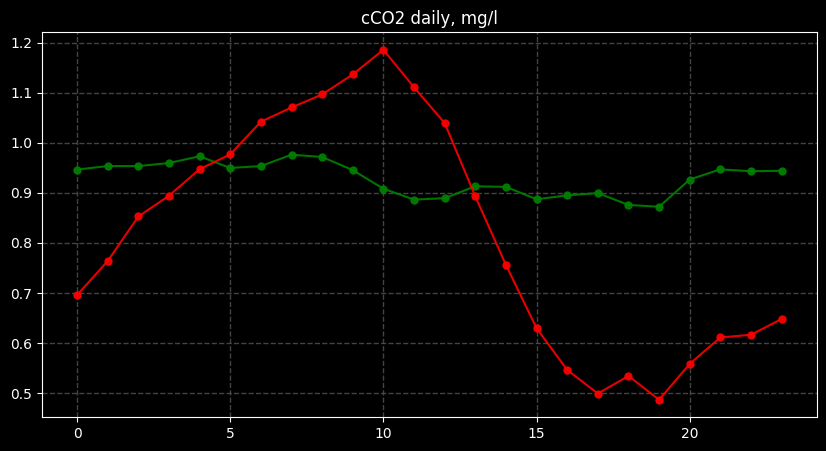

In [60]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
ax.set_title('cCO2 daily, mg/l')
err = daily[('cCO2sur', 'std')]
ax.plot('hour', daily[('cCO2sur','mean')], 'g.-', alpha=0.9, markersize=10, data=daily)
ax.plot('hour', daily[('cCO2bot','mean')], 'r.-', alpha=0.9, markersize=10, data=daily)
ax.grid(True, c='#555', alpha=0.8, linewidth=1, linestyle='--')
fig.savefig(serverPath+'cCO2daily.png', bbox_inches='tight')
daily

In [ ]:
sol_ch4 = bfunc.getSolubility(df['TempEqu1'], 'ch4')
sol_ch4

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['TempEqu1'], sol_ch4, 'ro')

In [ ]:
temp = [t for t in range(0, 50)]
dft = pd.DataFrame(temp, columns=['temperature'])
dft['sol'] = bfunc.getSolubility(dft['temperature'], 'ch4')

fig, ax = plt.subplots(1)

ax.plot(dft['temperature'], dft['sol'])